In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [2]:
df = pd.concat([pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv'),pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')], ignore_index=True)
df.drop('Unnamed: 0',axis=1,inplace=True) 
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
pd.DataFrame(df.isnull().value_counts())

,,,,,,,,,,,,,,,,,,,,,,0
trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1852394


In [4]:
def gender_binarizer(x):
    if x=='F':
        return 1
    if x=='M':
        return 0    
df['gender'] = df['gender'].transform(gender_binarizer)

In [5]:
df2 = df.loc[:99999,df.dtypes!=np.object]
df2

,cc_num,amt,gender,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,4.97,1,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,630423337322,107.23,1,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,38859492057661,220.11,0,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3534093764340240,45.00,0,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,375534208663984,41.96,0,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,2475085306462014,95.14,0,56152,44.2378,-95.2739,1507,1330443409,44.718105,-95.843397,0
99996,4005676619255478,8.75,0,70726,30.4590,-90.9027,71335,1330443447,29.931844,-90.610715,0
99997,3519232971341141,34.20,0,43903,40.4731,-80.9596,2208,1330443454,41.076153,-80.506107,0
99998,4040099974063068803,73.11,0,58769,48.3396,-102.2400,229,1330443491,48.535070,-102.524262,0


In [6]:
X = df2.drop(['cc_num','is_fraud'],axis=1)
y = df2['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


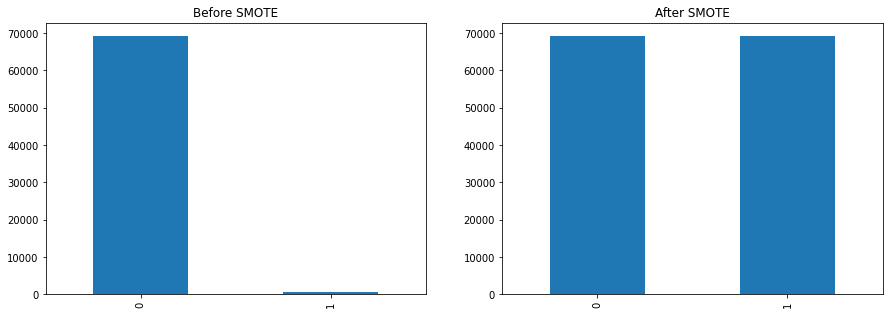

In [7]:
sm = SMOTE()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)

ax2.set_title('After SMOTE')  
pd.Series(y_train_new).value_counts().plot.bar(ax=ax2)
plt.show()

In [8]:
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

In [9]:
scaler = RobustScaler()
robust_df = scaler.fit_transform(df2)
robust_df = pd.DataFrame(robust_df)
  
scaler = StandardScaler()
standard_df = scaler.fit_transform(df2)
standard_df = pd.DataFrame(standard_df)
  
scaler = MinMaxScaler()
minmax_df = scaler.fit_transform(df2)
minmax_df = pd.DataFrame(minmax_df)

In [10]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
param_grid = {'n_neighbors': range(1,20)}
clf = RandomizedSearchCV(KNeighborsClassifier(), param_grid)
clf.fit(X_train,y_train)
clf_pred = clf.predict(X_test)

In [12]:
param_grid = {'n_neighbors': range(1,20)}
knn = RandomizedSearchCV(KNeighborsClassifier(), param_grid, verbose=3)
knn.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..................................n_neighbors=2; total time=   1.4s
[CV 2/5] END ..................................n_neighbors=2; total time=   1.4s
[CV 3/5] END ..................................n_neighbors=2; total time=   1.4s
[CV 4/5] END ..................................n_neighbors=2; total time=   1.3s
[CV 5/5] END ..................................n_neighbors=2; total time=   1.3s
[CV 1/5] END .................................n_neighbors=11; total time=   1.8s
[CV 2/5] END .................................n_neighbors=11; total time=   1.8s
[CV 3/5] END .................................n_neighbors=11; total time=   1.8s
[CV 4/5] END .................................n_neighbors=11; total time=   1.8s
[CV 5/5] END .................................n_neighbors=11; total time=   1.8s
[CV 1/5] END .................................n_neighbors=13; total time=   1.9s
[CV 2/5] END .................................n_

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': range(1, 20)},
                   verbose=3)

In [13]:
knn.best_params_ 

{'n_neighbors': 2}

In [14]:
knn_pred = knn.predict(X_test)

print(confusion_matrix(y_test,knn_pred))
print('\n')
print(classification_report(y_test,knn_pred))

[[29370   328]
 [   32   270]]


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29698
           1       0.45      0.89      0.60       302

    accuracy                           0.99     30000
   macro avg       0.73      0.94      0.80     30000
weighted avg       0.99      0.99      0.99     30000



# Gaussian Naive Bayes

In [15]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_pred = gnb.predict(X_test)

print(confusion_matrix(y_test,gnb_pred))
print('\n')
print(classification_report(y_test,gnb_pred))

[[28387  1311]
 [   95   207]]


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     29698
           1       0.14      0.69      0.23       302

    accuracy                           0.95     30000
   macro avg       0.57      0.82      0.60     30000
weighted avg       0.99      0.95      0.97     30000



# Decision Tree

In [16]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_test)

print(confusion_matrix(y_test,dtree_pred))
print('\n')
print(classification_report(y_test,dtree_pred))

[[29060   638]
 [   64   238]]


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     29698
           1       0.27      0.79      0.40       302

    accuracy                           0.98     30000
   macro avg       0.63      0.88      0.70     30000
weighted avg       0.99      0.98      0.98     30000



# Random Forest

In [17]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

[[29458   240]
 [   40   262]]


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     29698
           1       0.52      0.87      0.65       302

    accuracy                           0.99     30000
   macro avg       0.76      0.93      0.82     30000
weighted avg       0.99      0.99      0.99     30000



# AdaBoost

In [18]:
adabc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200)
adabc.fit(X_train,y_train)
adabc_pred = adabc.predict(X_test)

print(confusion_matrix(y_test,adabc_pred))
print('\n')
print(classification_report(y_test,adabc_pred))

[[28262  1436]
 [   57   245]]


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     29698
           1       0.15      0.81      0.25       302

    accuracy                           0.95     30000
   macro avg       0.57      0.88      0.61     30000
weighted avg       0.99      0.95      0.97     30000



# Bagging

In [19]:
bgc = BaggingClassifier(DecisionTreeClassifier(),n_estimators=200)
bgc.fit(X_train,y_train)
bgc_pred = bgc.predict(X_test)

print(confusion_matrix(y_test,bgc_pred))
print('\n')
print(classification_report(y_test,bgc_pred))

[[29312   386]
 [   47   255]]


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29698
           1       0.40      0.84      0.54       302

    accuracy                           0.99     30000
   macro avg       0.70      0.92      0.77     30000
weighted avg       0.99      0.99      0.99     30000



# Classification Evaluation via AUROC

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

classifiers = [GaussianNB(), 
               KNeighborsClassifier(n_neighbors= knn.best_params_.get('n_neighbors')),
               DecisionTreeClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               AdaBoostClassifier(random_state=42),
               BaggingClassifier(random_state=42)
              ]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

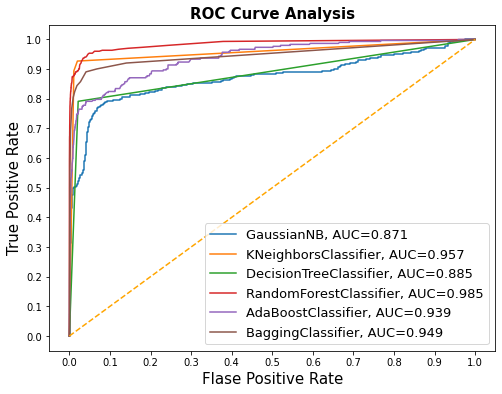

In [21]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()